<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/20_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%22_(%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе необходимо выполнить следующее задание:

1. Подготовьте датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip) для обучения модели `Embedding` по аналогии с уроком [20.2](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
2. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для эмбендинга.
3. Заморозьте слой эмбединга.
4. Выберите любых 5 писателей и обучите модель на них, не забудьте про балансировку (предварительно выделите 10% датасета на проверочную выборку и 10% на тестовую). Выбирайте писателей с большими объемами текстов, что даст большее число примеров для обучения.
5. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
6. Если сможете добиться точности более 85% получите 4 балла.
7. Хотите 5 баллов независимо от точности? Изучите самостоятельно и примените токенизатор [Razdel](https://github.com/natasha/razdel#usage) для данной задачи, вместо встроенного токенизатора для Keras.

**Подсказка**. Так как проверка задания проводиться по средней точности на тестовых образцах (вычисляем по диагонали матрицы ошибок), то для улучшения данного показателя используйте колбэк функцию `keras.callbacks.ModelCheckpoint` из урока [19.2](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft) для сохранения лучшей эпохи.

**Подсказка 2**. Часто при работе с текстовыми данными вы можете заметить, что при использовании параметра `validation_split`, в методе `fit()`, точность на проверочной выборке ведет себя странно. В этом случае выделите проверочную выборку самостоятельно и используйте ее с помощью параметра `validation_data`.

In [1]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec

--2024-10-12 07:36:30--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.6MB/s    in 3.6s    

2024-10-12 07:36:35 (14.1 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [2]:
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

import keras
data_path = keras.utils.get_file("russian_literature.zip", "https://storage.yandexcloud.net/academy.ai/russian_literature.zip")

!unzip -qo "{data_path}" -d ./dataset
CLASS_LIST=["Dostoevsky", "Tolstoy", "Gorky", "Bryusov", "Turgenev"]

21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


In [3]:
import glob # Вспомогательный модуль для работы с файловой системой

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)

# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [19]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())
seq_train_balance = [seq_train[cls][:100_000] for cls in range(len(CLASS_LIST))]

In [20]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 3843964 слов


In [21]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 100000 слов, доля в общей базе: 2.60%
Tolstoy - 100000 слов, доля в общей базе: 2.60%
Gorky - 100000 слов, доля в общей базе: 2.60%
Bryusov - 100000 слов, доля в общей базе: 2.60%
Turgenev - 100000 слов, доля в общей базе: 2.60%
Среднее значение слов:  100000.0
Медианное значение слов:  100000.0


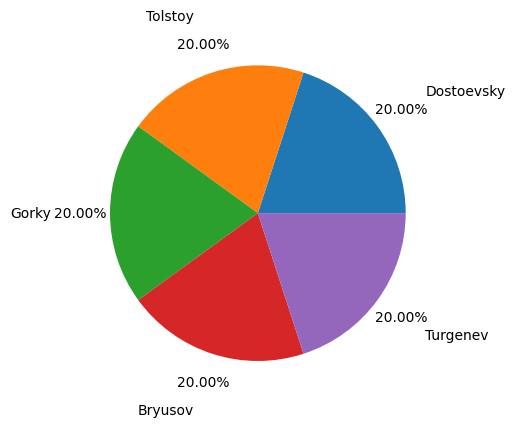

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%')                     # формат для % (2 знака после запятой)

plt.show()

In [23]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [24]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [25]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')
print()
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для обучающей выборки: (4455, 1000)
Форма выходных данных (меток) для обучающей выборки: (4455, 5)

Форма входных данных для тестовой выборки: (455, 1000)
Форма выходных данных (меток) для тестовой выборки: (455, 5)


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(BatchNormalization())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.6))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
import numpy as np

word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [29]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

ValueError: You called `set_weights(weights)` on layer 'embedding_1' with a weight list of length 1, but the layer was expecting 0 weights.

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)]

history = model.fit(x_train, y_train, epochs=100, batch_size=256, validation_split=0.05)
# model.save_weights('pre_trained_model.h5') # можно сохранять не только модели, но и веса

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.5510e-04 - val_accuracy: 0.4260 - val_loss: 1.8380
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 6.3481e-05 - val_accuracy: 0.5067 - val_loss: 1.6549
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 3.1389e-05 - val_accuracy: 0.5336 - val_loss: 1.6100
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 2.2716e-05 - val_accuracy: 0.4888 - val_loss: 1.7874
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 2.4012e-05 - val_accuracy: 0.4753 - val_loss: 1.9625
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 9.6282e-06 - val_accuracy: 0.4395 - val_loss: 2.1720
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 2.3124e-05 - val_accuracy: 0.3498 - val_loss: 2.6958
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - lo

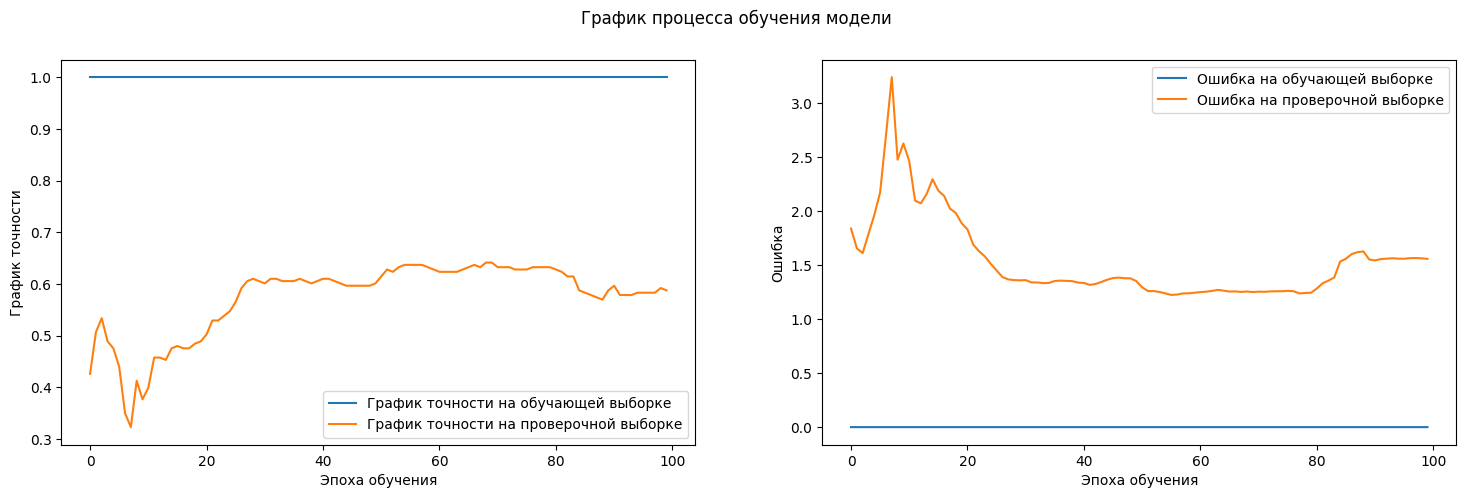

In [34]:
show_plot(history)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


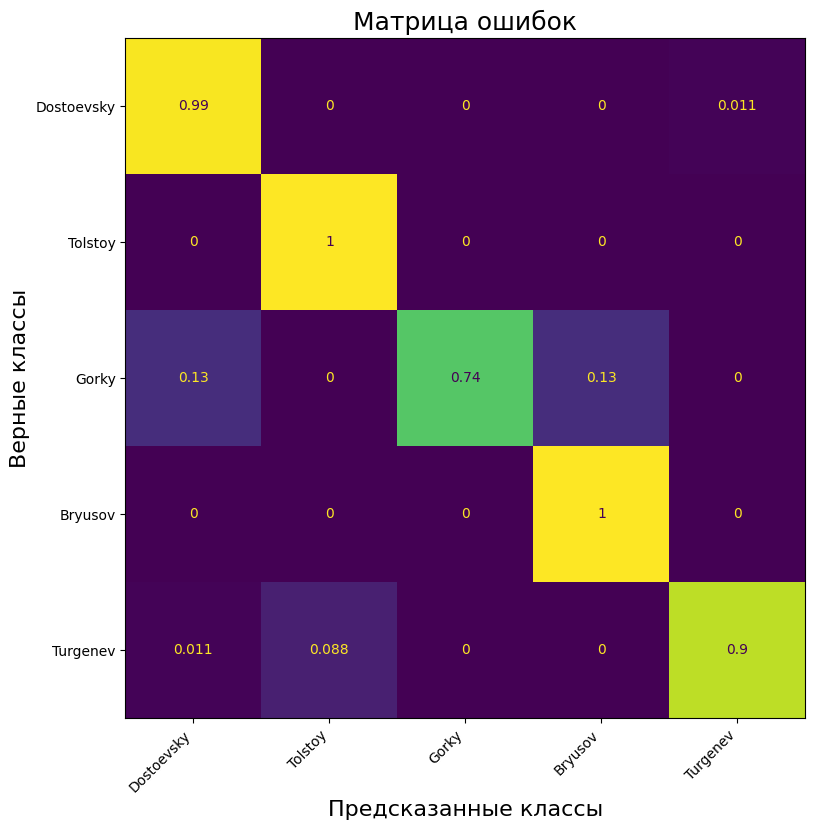


Средняя точность распознавания:  93%


In [35]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)